In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [3]:
BASE = Path("../data/processed")
X_tr = pd.read_csv(BASE / "X_train.csv", index_col=0,parse_dates=True)
Y_tr = pd.read_csv(BASE / "y_train.csv", index_col=0,parse_dates=True)

In [4]:
X_train = X_tr.copy()

### On impute naïvement les valeurs manquantes par la moyenne de chaque série temporelle.

In [5]:
df_imputed_naive = X_train.interpolate(limit_direction='both', axis=0)
df_imputed_naive = df_imputed_naive.fillna(df_imputed_naive.mean())

<Axes: title={'center': 'Aperçu des courbes après imputation naïve'}, xlabel='Horodate'>

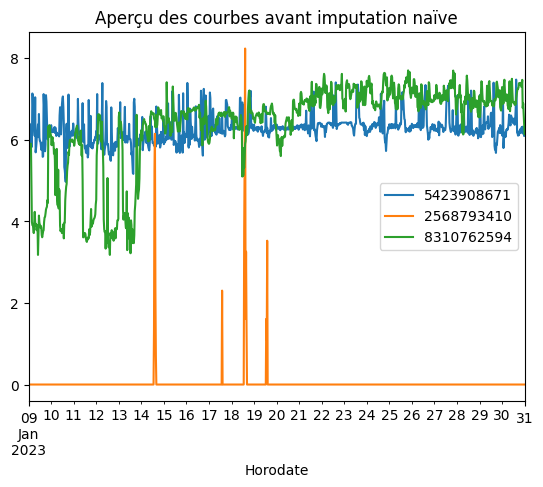

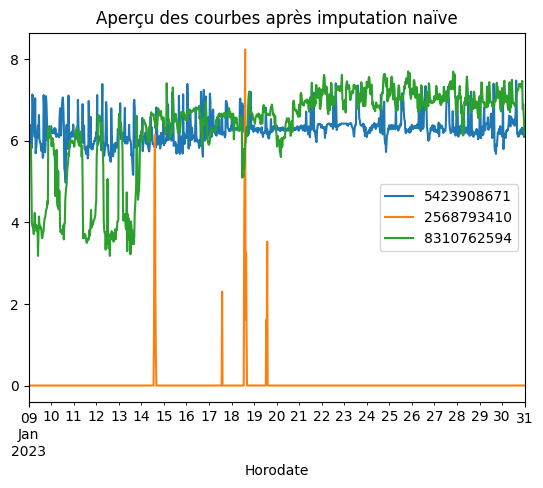

In [5]:
X_tr.iloc[:, :3].plot(title="Aperçu des courbes avant imputation naïve")
df_imputed_naive.iloc[:, :3].plot(title="Aperçu des courbes après imputation naïve")

### On applique un clustering KMeans.

In [6]:
X_for_cluster = df_imputed_naive.copy()


In [7]:
X_for_cluster = X_for_cluster.T

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_for_cluster)

In [9]:
n_clusters = 4 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)

In [10]:
cluster_labels = pd.Series(labels, index=X_for_cluster.index, name='cluster')

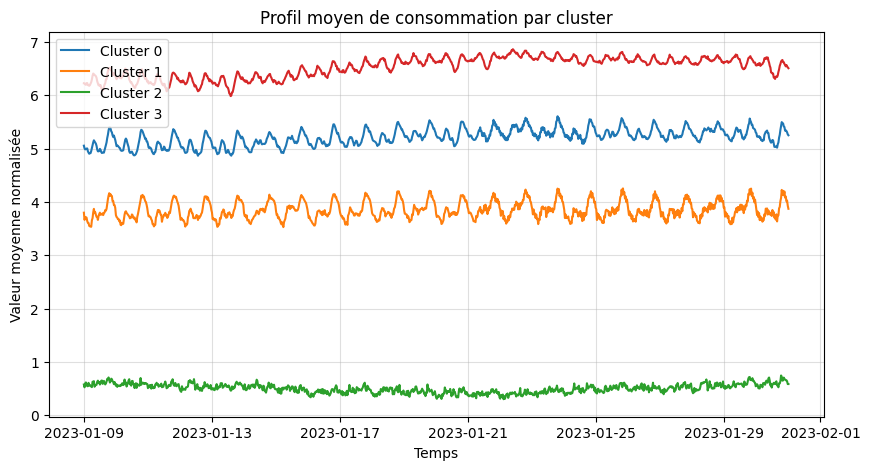

In [11]:
plt.figure(figsize=(10, 5))
for k in sorted(cluster_labels.unique()):
    mean_profile = df_imputed_naive.loc[:, cluster_labels == k].mean(axis=1)
    plt.plot(mean_profile, label=f"Cluster {k}")
plt.title("Profil moyen de consommation par cluster")
plt.xlabel("Temps")
plt.ylabel("Valeur moyenne normalisée")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


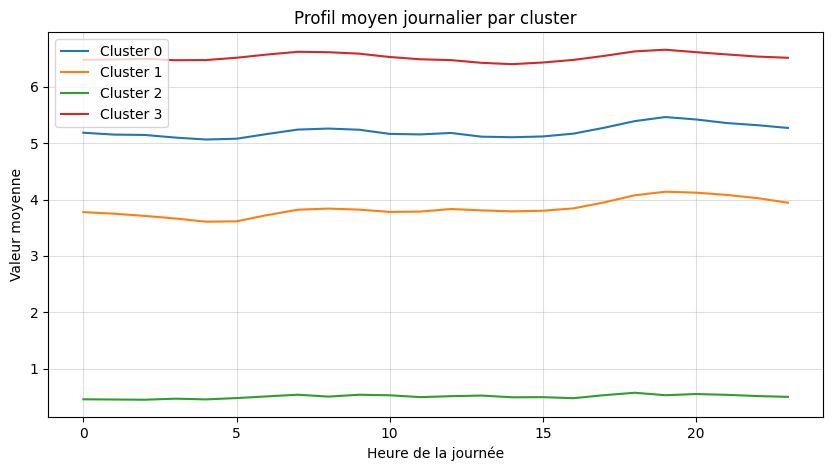

In [12]:
# Suppose un pas de 30 minutes → 48 points par jour
df_daily = df_imputed_naive.groupby(df_imputed_naive.index.hour).mean()

plt.figure(figsize=(10, 5))
for k in sorted(cluster_labels.unique()):
    plt.plot(df_daily.index, df_daily.loc[:, cluster_labels == k].mean(axis=1), label=f'Cluster {k}')
plt.title("Profil moyen journalier par cluster")
plt.xlabel("Heure de la journée")
plt.ylabel("Valeur moyenne")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


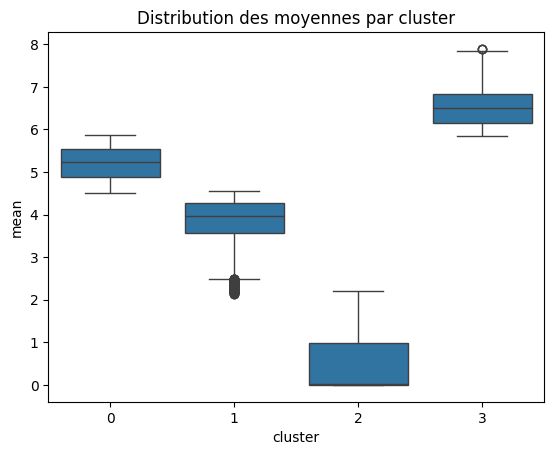

In [13]:
import seaborn as sns

# Crée un DataFrame avec des stats de colonnes
df_stats = pd.DataFrame({
    'mean': df_imputed_naive.mean(),
    'std': df_imputed_naive.std(),
    'range': df_imputed_naive.max() - df_imputed_naive.min(),
    'cluster': cluster_labels
})

# Exemple : distribution des moyennes
sns.boxplot(data=df_stats, x='cluster', y='mean')
plt.title("Distribution des moyennes par cluster")
plt.show()


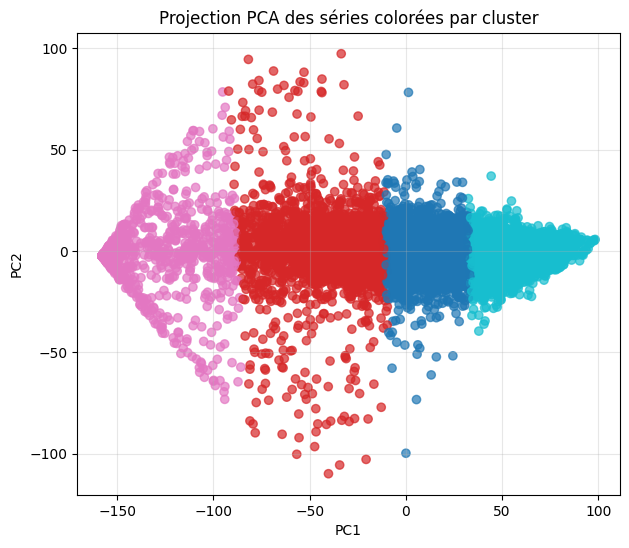

In [14]:
pca = PCA(n_components=2)
proj = pca.fit_transform(df_imputed_naive.T.fillna(0))

plt.figure(figsize=(7, 6))
plt.scatter(proj[:, 0], proj[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title("Projection PCA des séries colorées par cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
for k in sorted(cluster_labels.unique()):
    subset = df_imputed_naive.loc[:, cluster_labels == k]
    corr_mean = subset.corr().values[np.triu_indices_from(subset.corr(), k=1)].mean()
    print(f"Cluster {k}: corrélation moyenne = {corr_mean:.2f}")


On observe que les données sont différenciées selon la composantes PC1 uniquement. Cela suggère que les profils de consommation sont principalement différenciés par leur niveau global de consommation plutôt que par leur forme. 

On va essayer de normaliser les données pour se concentrer sur la forme des profils.

In [6]:
X_temp = df_imputed_naive.T
X_temp = (X_temp - X_temp.mean(axis=1).values[:, None]) / (X_temp.std(axis=1).values[:, None] + 1e-8)
X_scaled = X_temp.fillna(0).values

In [7]:
def plot_cluster_profiles(df, cluster_labels, n_clusters):
    plt.figure(figsize=(10, 5))
    for k in range(n_clusters):
        mean_profile = df.loc[:, cluster_labels == k].mean(axis=1)
        plt.plot(mean_profile, label=f'Cluster {k}')
    plt.title(f'Profil moyen par cluster (k={n_clusters})')
    plt.xlabel('Temps')
    plt.ylabel('Valeur moyenne normalisée')
    plt.legend()
    plt.grid(alpha=0.4)
    plt.show()

Text(0.5, 1.0, 'PCA après centrage/normalisation par série')

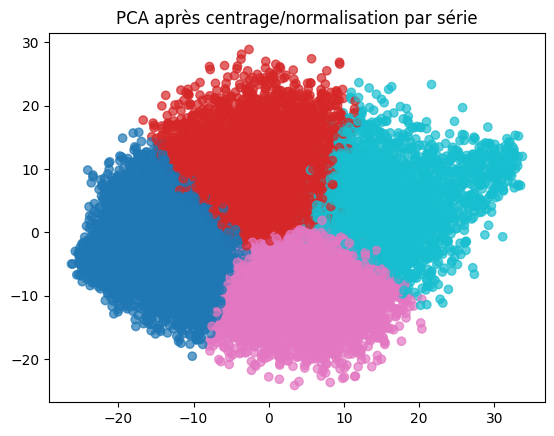

In [9]:
kmeans3 = KMeans(n_clusters=3, random_state=42, n_init=20)
kmeans4 = KMeans(n_clusters=4, random_state=42, n_init=20)
kmeans5 = KMeans(n_clusters=5, random_state=42, n_init=20)

labels3 = kmeans3.fit_predict(X_scaled)
labels4 = kmeans4.fit_predict(X_scaled)
labels5 = kmeans5.fit_predict(X_scaled)


pca = PCA(n_components=2)
proj = pca.fit_transform(X_scaled)
plt.scatter(proj[:, 0], proj[:, 1], c=labels4, cmap='tab10', alpha=0.7)
plt.title("PCA après centrage/normalisation par série")


In [18]:
for k in [3, 4, 5,6,7,8]:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k} → silhouette={score:.3f}")


k=3 → silhouette=0.047
k=4 → silhouette=0.043
k=5 → silhouette=0.039
k=6 → silhouette=0.038
k=7 → silhouette=0.027
k=8 → silhouette=0.026


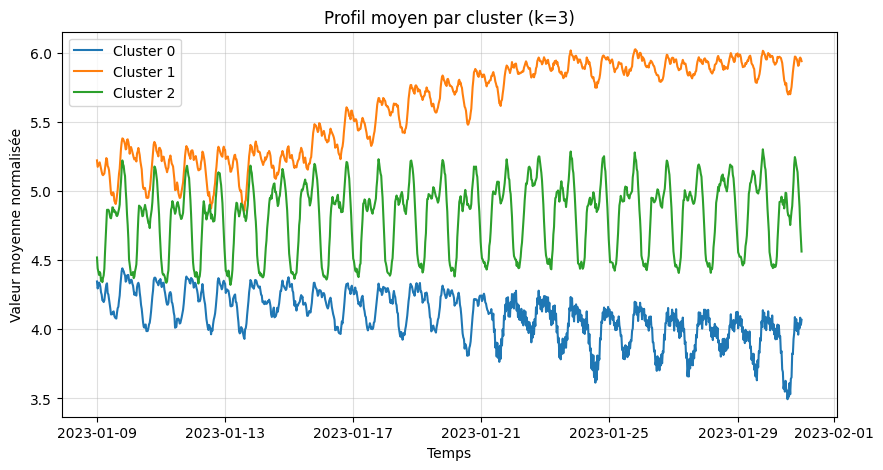

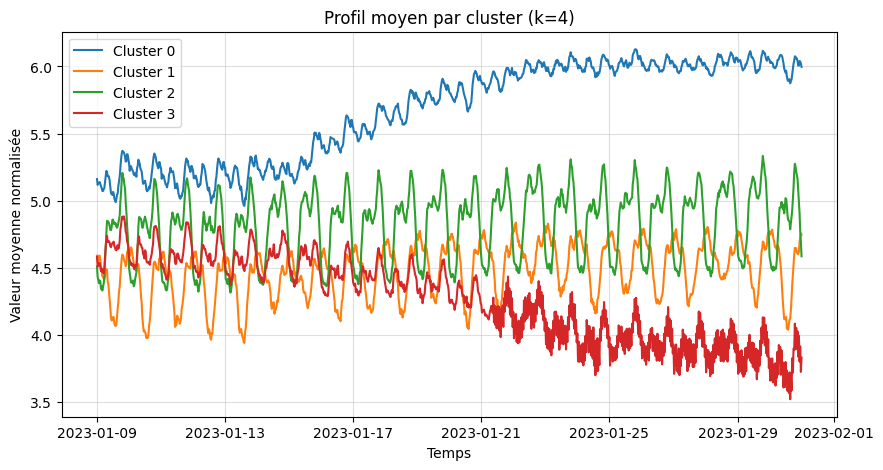

In [10]:
plot_cluster_profiles(df_imputed_naive, labels3, 3)
plot_cluster_profiles(df_imputed_naive, labels4, 4)

In [11]:
cluster_labels_k4 = pd.Series(labels4, index=df_imputed_naive.columns, name="cluster")

In [12]:
df_clusters = cluster_labels_k4.reset_index()
df_clusters.columns = ["col", "cluster"]

In [13]:
os.makedirs("../data/clusters", exist_ok=True)

df_clusters.to_csv("../data/clusters/cluster_labels_k4.csv", index=False)